<a href="https://colab.research.google.com/github/Saharsh2k5/ML_ASSIGNMENT_2/blob/main/TASK3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('/content/sample_data/Screenshot 2024-09-10 235159.png'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2024-09-20 11:13:17--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 18.64.236.71, 18.64.236.19, 18.64.236.6, ...
Connecting to segment-anything.com (segment-anything.com)|18.64.236.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.04s   

2024-09-20 11:13:17 (5.73 MB/s) - ‘dog.jpg’ saved [221810/221810]



torch.Size([3, 1365, 2048])


MinMaxScaler()

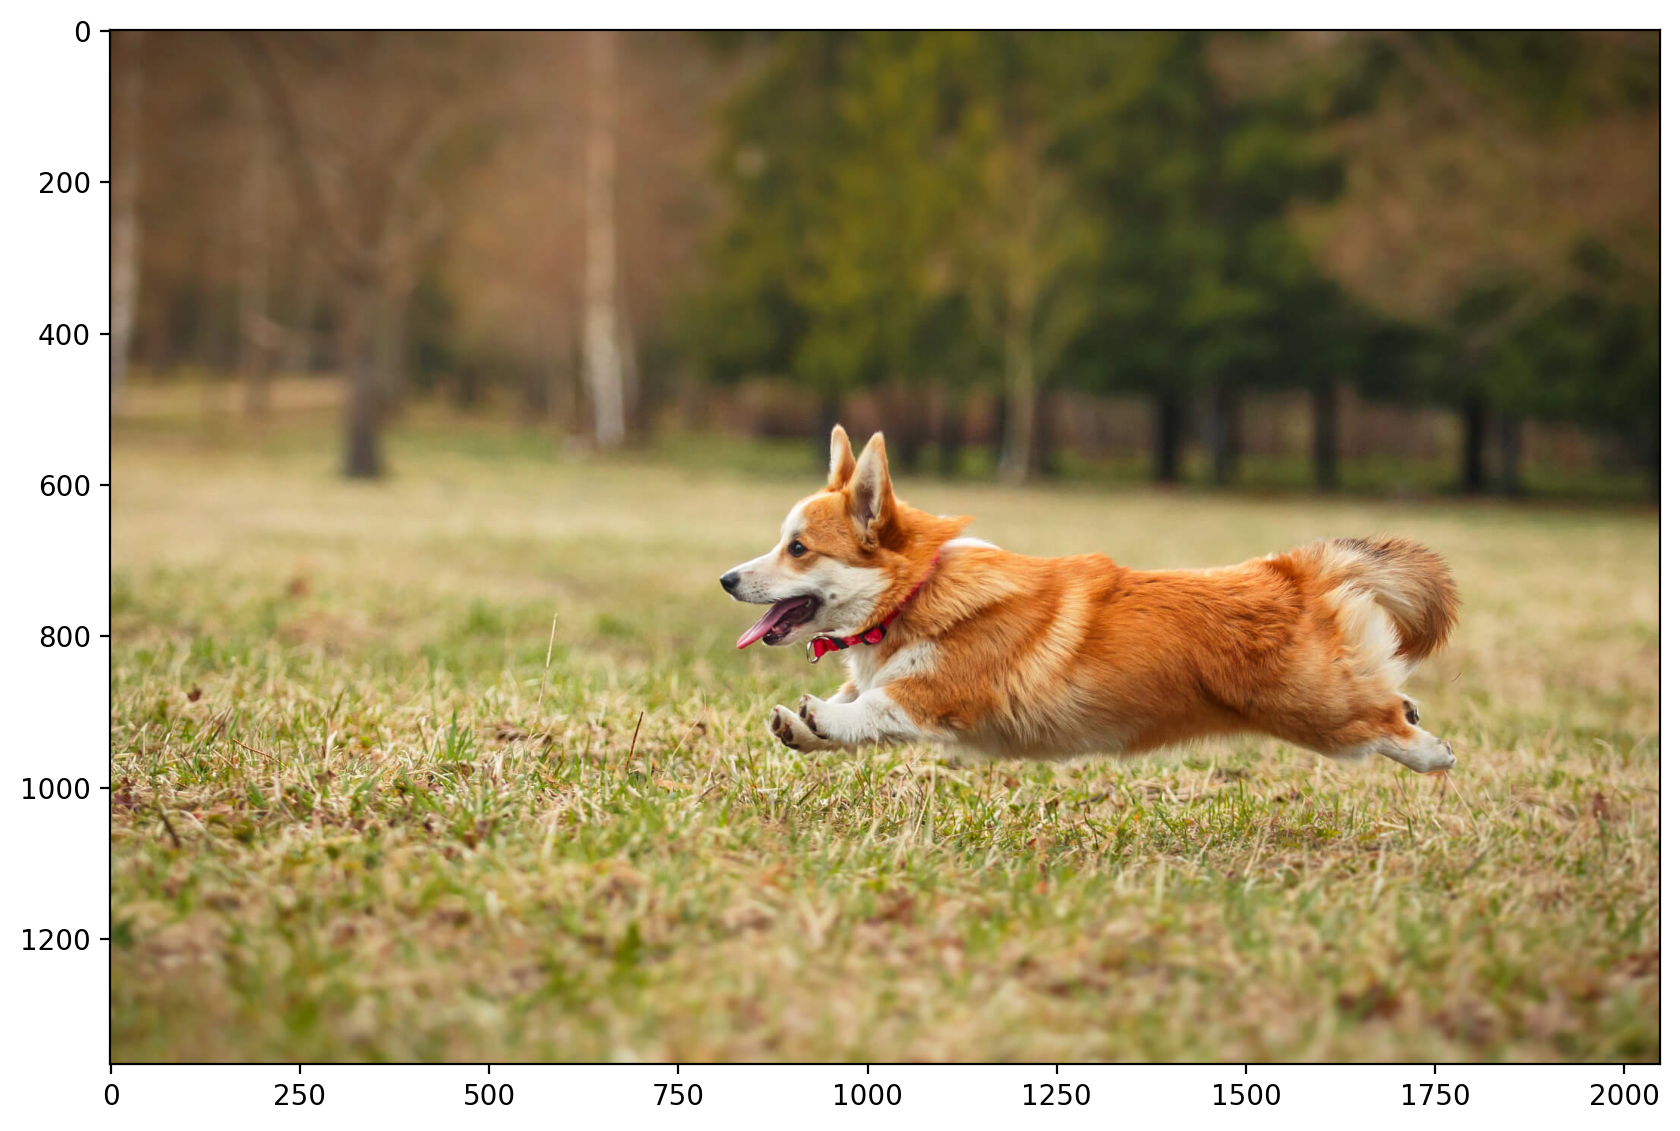

In [ ]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.14

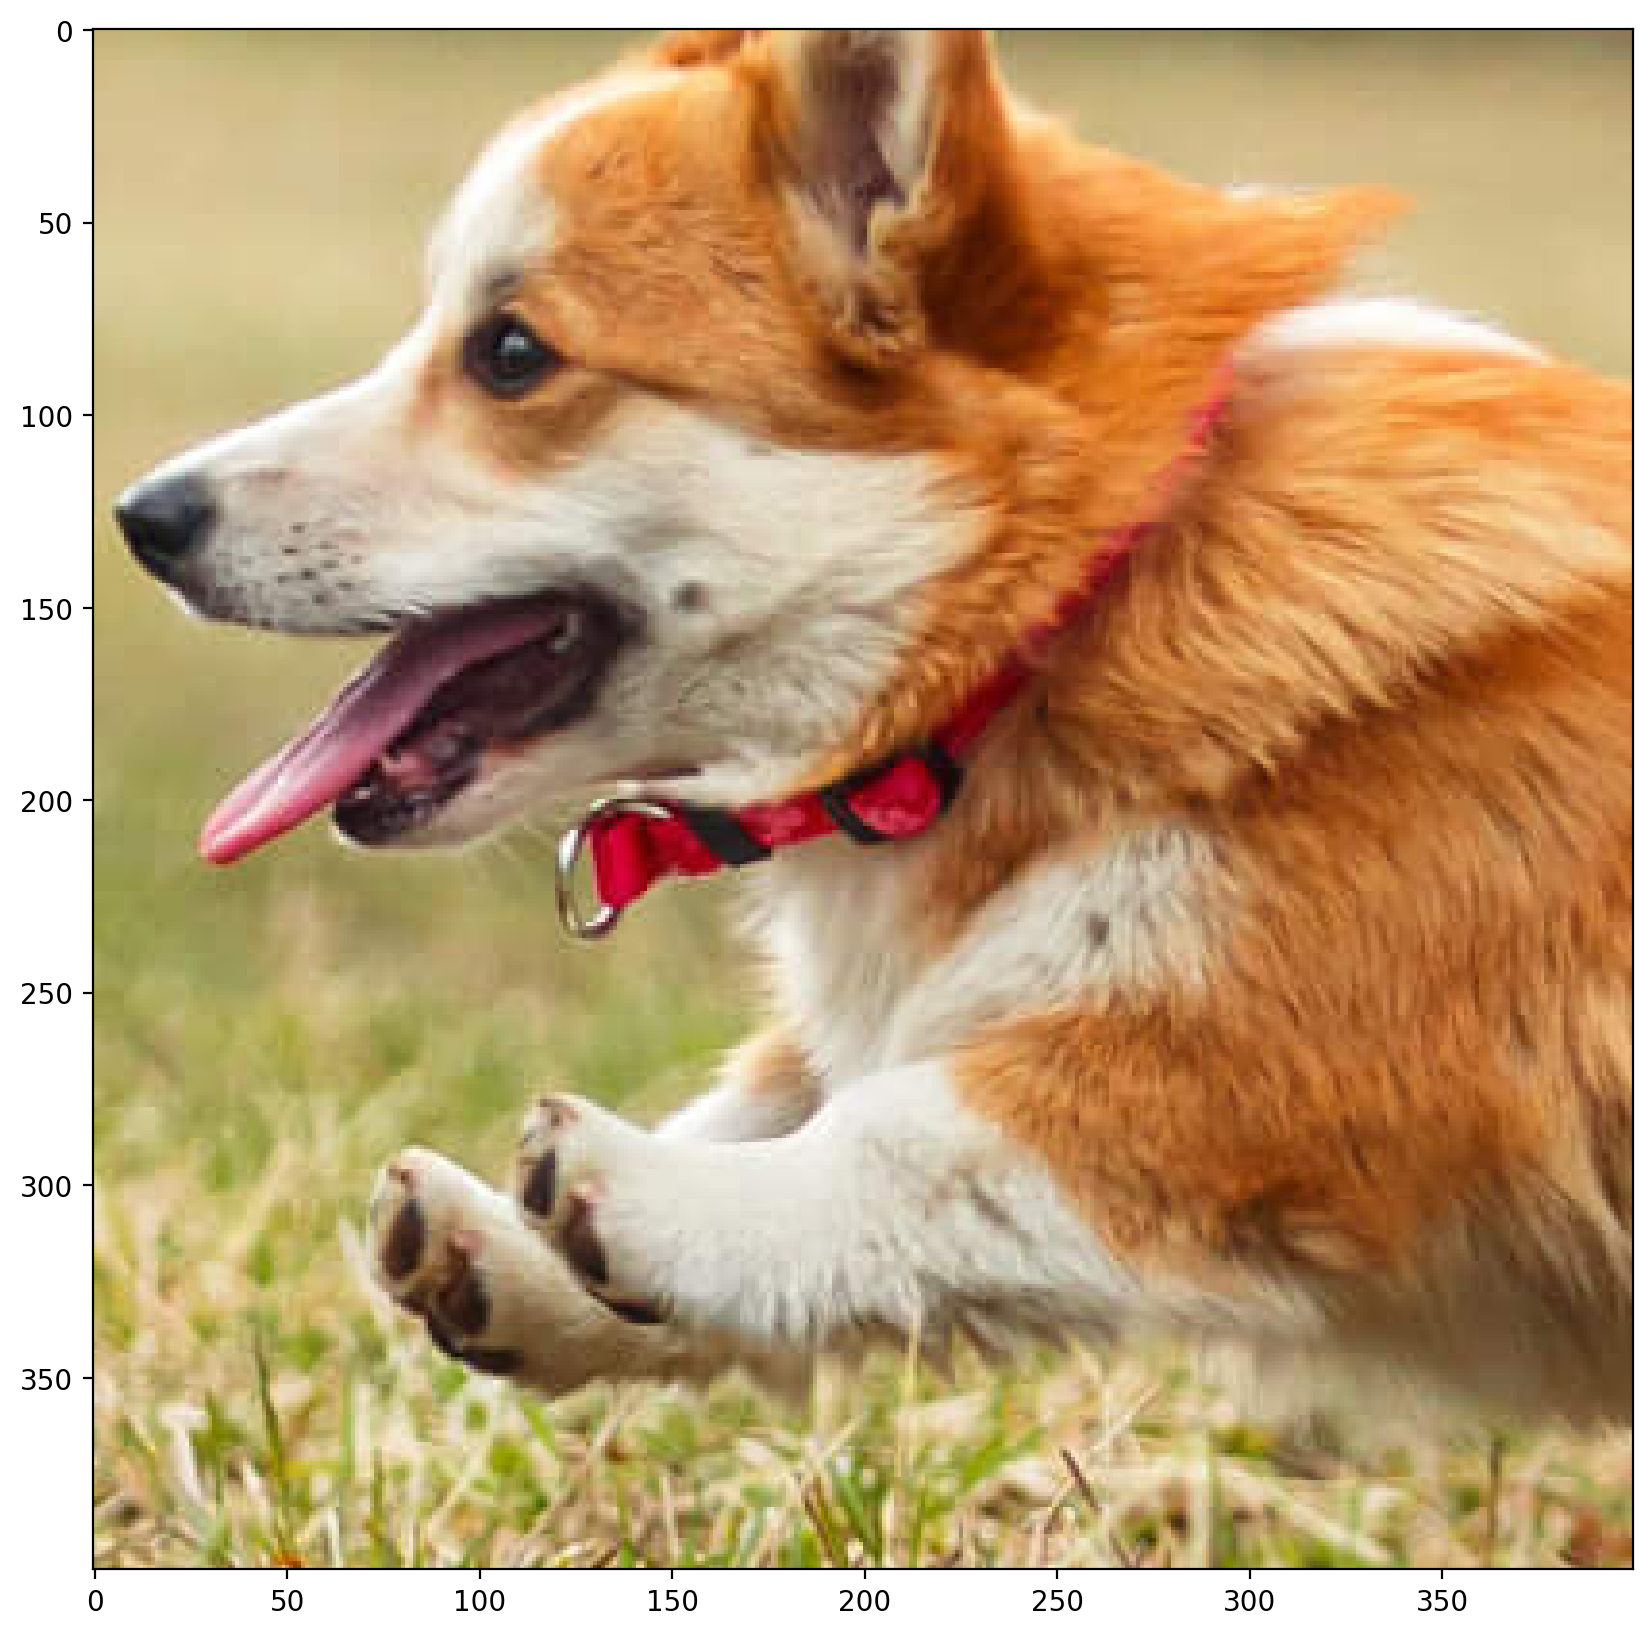

In [ ]:
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
print(scaled_img)
OriginalImg = torchvision.transforms.functional.crop(scaled_img.cpu(), 600, 800, 400, 400)
print(OriginalImg.shape)
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(OriginalImg, 'c h w -> h w c').numpy())

torch.Size([3, 200, 200])


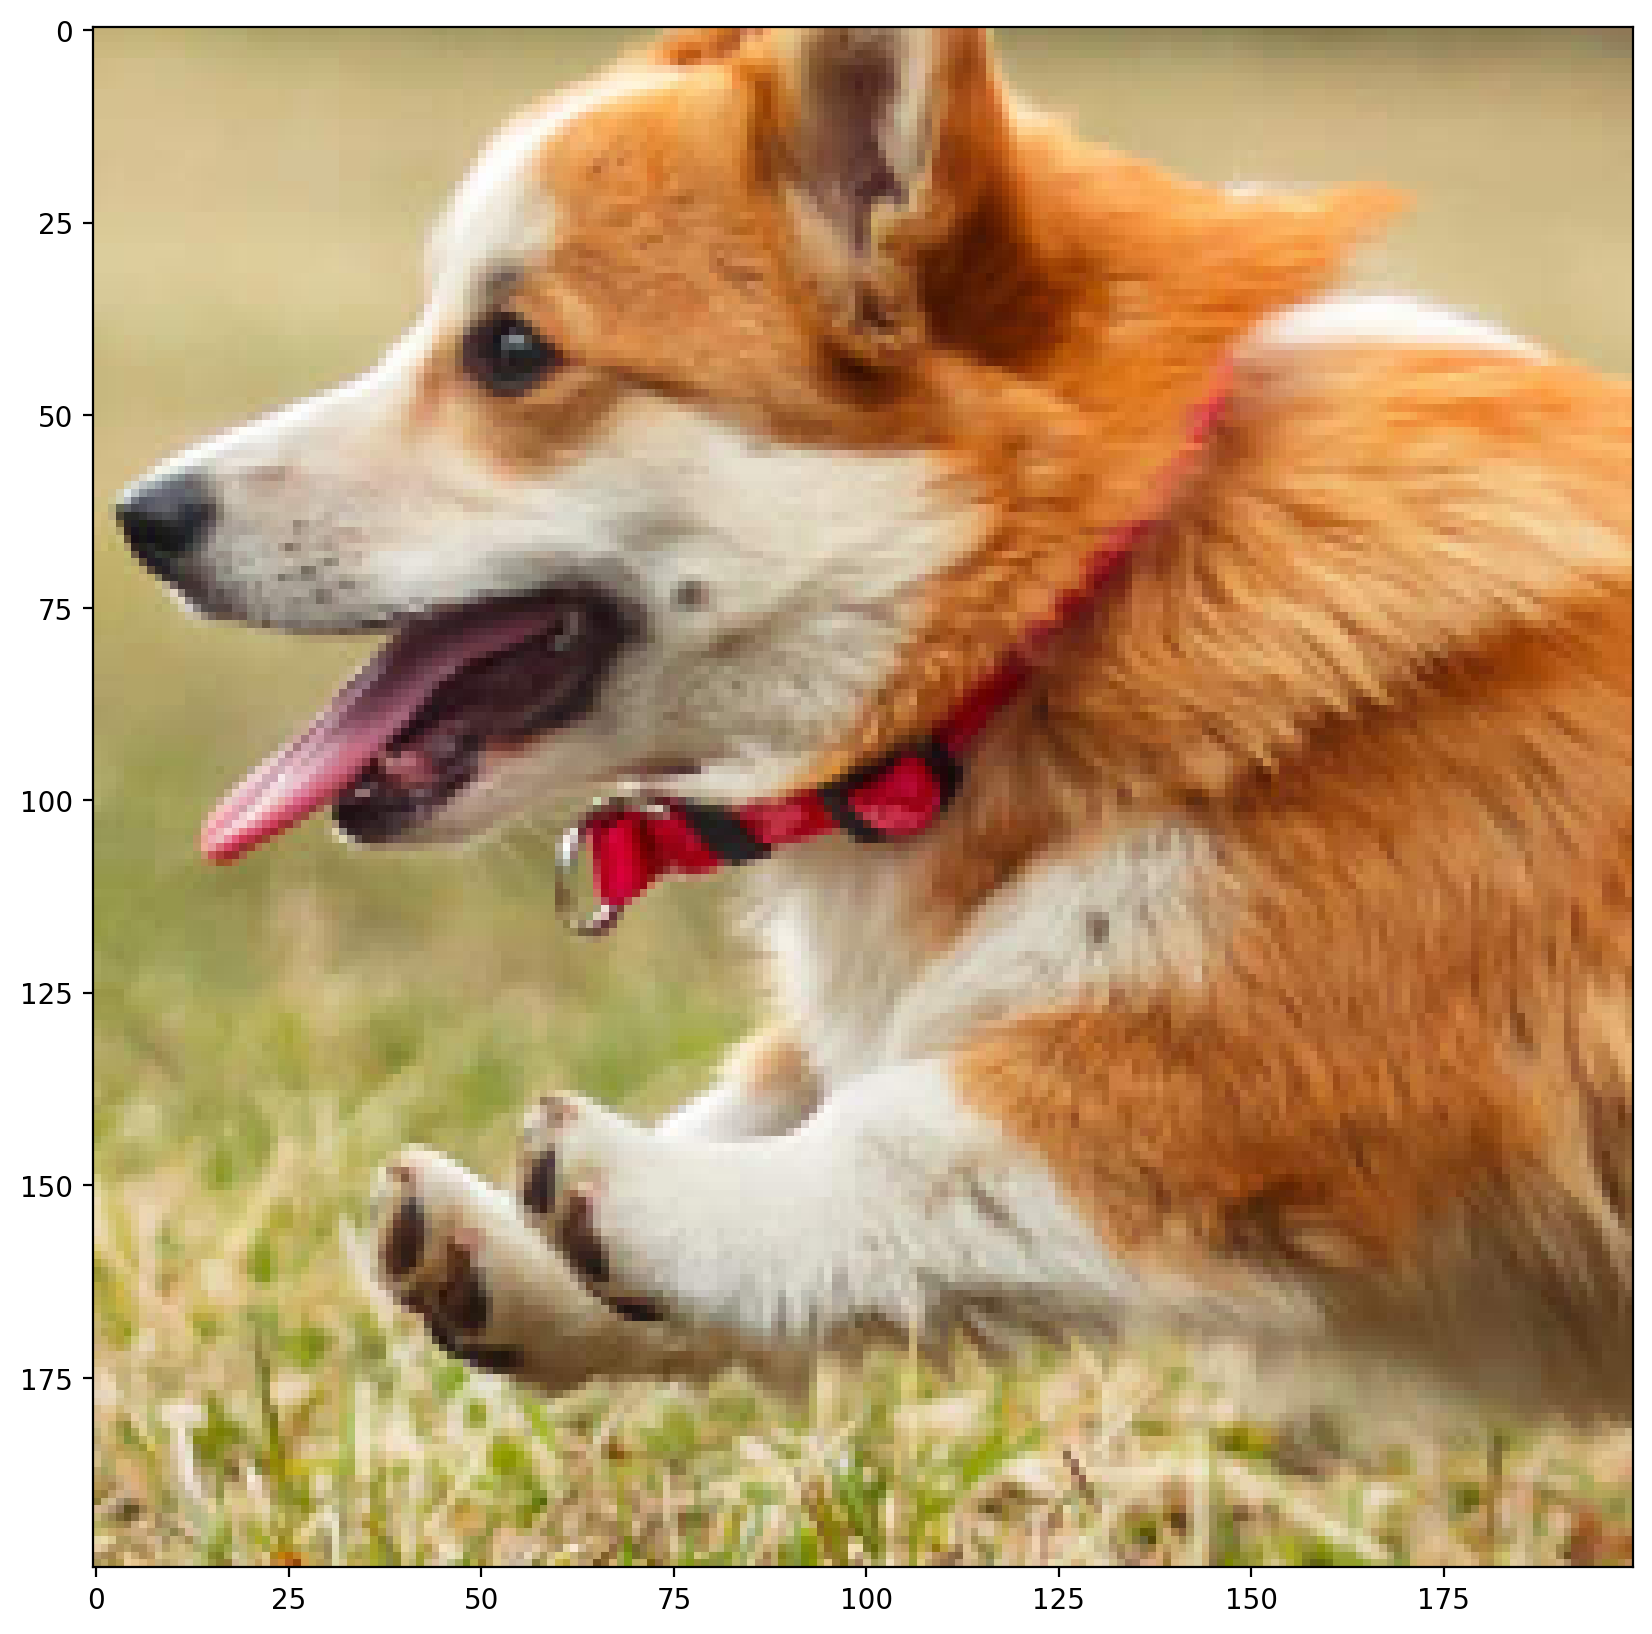

In [ ]:
scale = 2
num_channels, height, width = OriginalImg.shape
height //= scale
width //= scale
low_res_img = torch.zeros((num_channels,height,width)).to(device)
for i in range(height):
  for j in range(width):
    low_res_img[:, i, j] = torch.mean(OriginalImg[:, 2*i:2*i+2, 2*j:2*j+2], dim=(1, 2))
print(low_res_img.shape)
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())

In [ ]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
X, Y = create_coordinate_map(low_res_img)
print("Shape of X = ",X.shape,"\nShape of Y = ", Y.shape)
print("X:\n",X,"\nY:\n", Y)
scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)
print(scaled_X.shape)
print(scaled_X)

Shape of X =  torch.Size([40000, 2]) 
Shape of Y =  torch.Size([40000, 3])
X:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]]) 
Y:
 tensor([[0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        ...,
        [0.6245, 0.5020, 0.1912],
        [0.6814, 0.5206, 0.2608],
        [0.7373, 0.5461, 0.3461]])
torch.Size([40000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])


In [ ]:
num_features = 8500
sigma = 0.03
rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)
print(X_rff.shape)

torch.Size([40000, 8500])


In [ ]:

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
in_features = X_rff.shape[1]
out_features = 3
net = LinearModel(in_features,out_features).to(device)
net
Y = Y.to(device)
train(net, 0.01, X_rff, Y, 2500)

Epoch 0 loss: 0.371302
Epoch 100 loss: 0.002687
Epoch 200 loss: 0.002430
Epoch 300 loss: 0.002380
Epoch 400 loss: 0.002358
Epoch 500 loss: 0.002344
Epoch 600 loss: 0.002334
Epoch 700 loss: 0.002325
Epoch 800 loss: 0.002319
Epoch 900 loss: 0.002313
Epoch 1000 loss: 0.002308
Epoch 1100 loss: 0.002304
Epoch 1200 loss: 0.002300
Epoch 1300 loss: 0.002297
Epoch 1400 loss: 0.002294
Epoch 1500 loss: 0.002291
Epoch 1600 loss: 0.002288
Epoch 1700 loss: 0.002286
Epoch 1800 loss: 0.002283
Epoch 1900 loss: 0.002281
Epoch 2000 loss: 0.002279
Epoch 2100 loss: 0.002277
Epoch 2200 loss: 0.002275
Epoch 2300 loss: 0.002274
Epoch 2400 loss: 0.002272
Epoch 2500 loss: 0.002271


0.002270550699904561

In [ ]:
import gc

In [ ]:
X_, Y_ = create_coordinate_map(low_res_img, scale = 2)
print("Shape of X_ = ",X_.shape,"\nShape of Y_ = ", Y_.shape)
print("X_:\n",X_,"\nY_:\n", Y_)
scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)
print(scaled_X_.shape)
print(scaled_X_)

Shape of X_ =  torch.Size([160000, 2]) 
Shape of Y_ =  torch.Size([40000, 3])
X_:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]]) 
Y_:
 tensor([[0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        [0.7706, 0.6961, 0.4765],
        ...,
        [0.6245, 0.5020, 0.1912],
        [0.6814, 0.5206, 0.2608],
        [0.7373, 0.5461, 0.3461]])
torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]])


In [ ]:
# del X_rff,X,Y,scaled_X_
gc.collect

<function gc.collect(generation=2)>

In [ ]:
X_rff = rff.transform(scaled_X_.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)

In [ ]:
print(X_rff.shape)
print(X_rff)

torch.Size([160000, 8500])
tensor([[ 0.0136,  0.0118, -0.0153,  ...,  0.0147, -0.0113, -0.0040],
        [ 0.0153,  0.0125, -0.0149,  ...,  0.0153, -0.0125, -0.0033],
        [ 0.0144,  0.0131, -0.0131,  ...,  0.0140, -0.0135, -0.0025],
        ...,
        [-0.0095,  0.0109, -0.0102,  ..., -0.0018, -0.0138,  0.0116],
        [-0.0037,  0.0100, -0.0133,  ..., -0.0070, -0.0145,  0.0111],
        [ 0.0026,  0.0091, -0.0150,  ..., -0.0113, -0.0150,  0.0106]])


torch.Size([160000, 3])


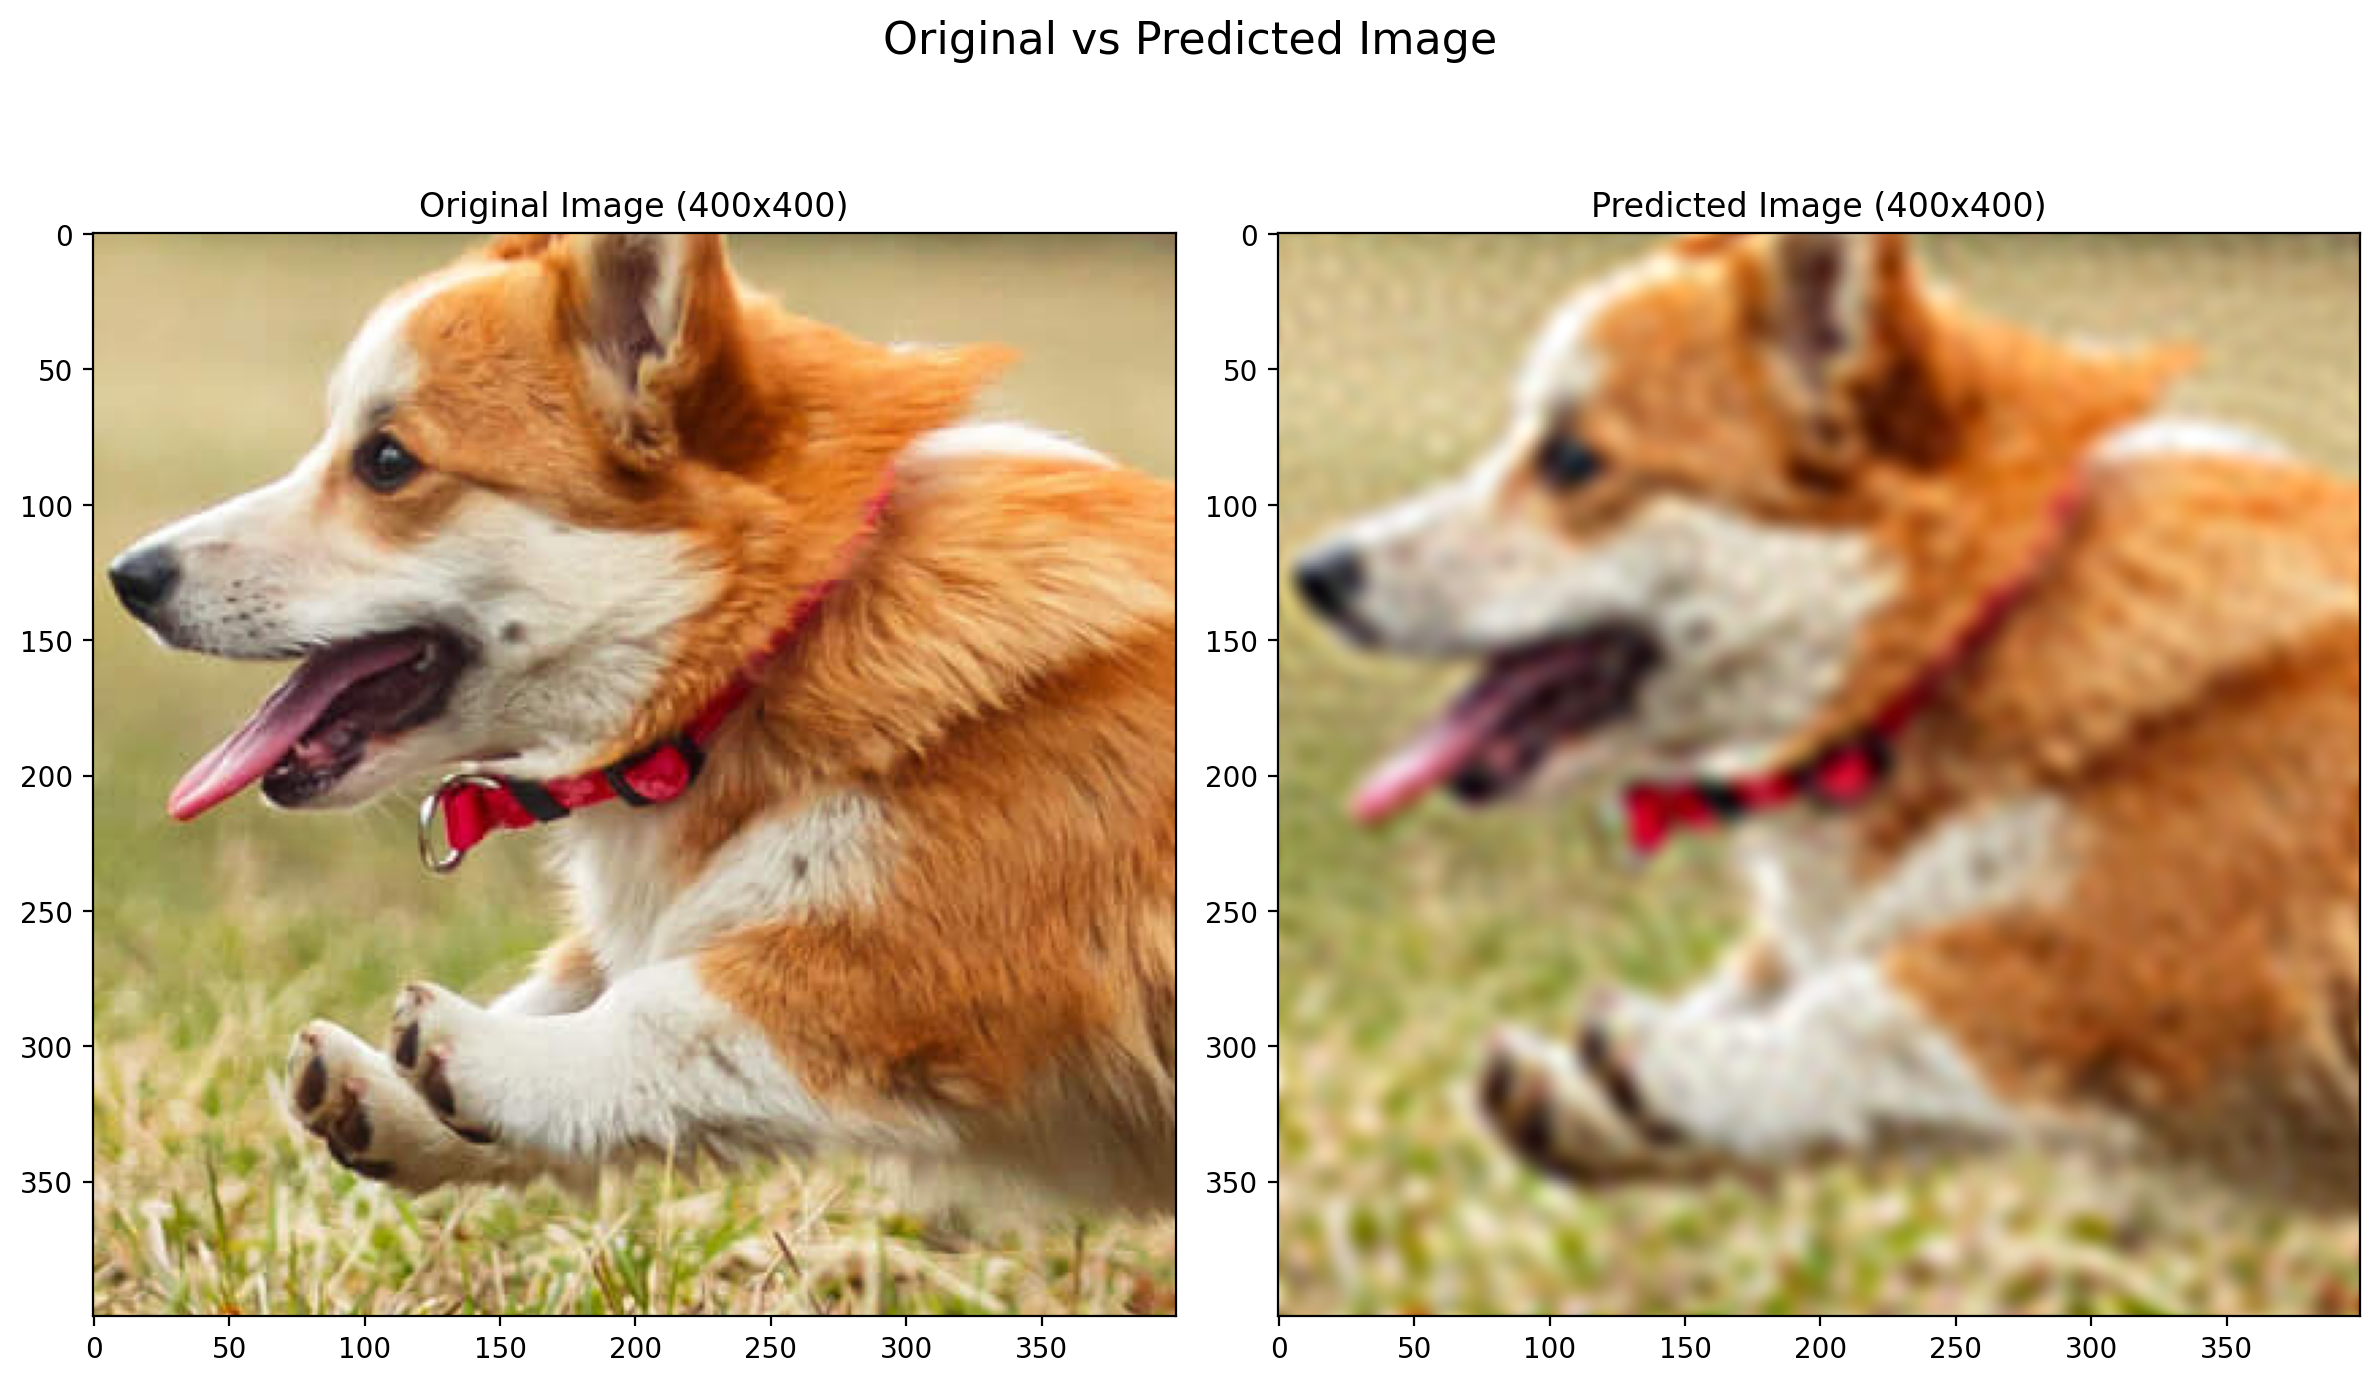

In [ ]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    if(return_Output == 1):
        return pred_img
Y = plot_Original_vs_Predicted_Img(OriginalImg, X_rff, net, return_Output = 1)

In [ ]:
def calRMSE_and_PSNR(img1, img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    device = img1.device
    img2 = img2.to(device)

    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OriginalImg = OriginalImg.to(device)
Y = Y.to(device)

rmse, psnr = calRMSE_and_PSNR(OriginalImg, Y)
print("RMSE: ", rmse, "\nPSNR: ", psnr)


RMSE:  0.05339377000927925 
PSNR:  25.4501895904541
